# 프로젝트 - Movielens 영화 SBR

In [19]:
# 주요 라이브러리 버전 확인
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [20]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [21]:
data_path = Path(os.getenv('HOME')+'/aiffel/Module10_Recommendation/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    # time 형식을 기존과 맞게 고쳐보기
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- SessionID 대신 UserID 항목이 들어갔다는 점
    - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있다.
    - 그래서 이번에는 UserID가 SessionID 역할을 해야 한다.
- Rating 정보가 포함
    - 무시하고 제외할 수 있지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다.
    - Rating이 낮은 데이터를 어떻게 처리할지도 고민 필요
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재

## Step 1. 데이터의 전처리

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
# data = cleanse_recursive(data, shortest=2, least_click=5)
# data

In [24]:
# 1) 세션의 길이 분포 확인
print("전체 세션 수:", data['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(data.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (data.groupby('UserId').size() == 1).mean())

전체 세션 수: 6040
세션별 길이(상위 10개):
UserId
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
dtype: int64
길이 1 세션 비율: 0.0


In [25]:
# 학습/검증/테스트 데이터셋 분리
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    cutoff_time = final_time - dt.timedelta(days=n_days)

    # Train: cutoff 이전의 데이터
    train = data[data['Time'] < cutoff_time]

    # Test: cutoff 이후의 데이터, 단 아이템은 train에 있던 것만
    test = data[(data['Time'] >= cutoff_time) & (data['ItemId'].isin(train['ItemId']))]

    return train, test

In [26]:
tr, test = split_by_date(data, n_days=14)  # 마지막 14일을 테스트용으로 분리
tr, val = split_by_date(tr, n_days=14)  # Trai셋에서 마지막 14일을 검증용으로 분리

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [28]:
# 데이터 분리 이후 각각 클렌징
# 길이가 1인 User 제거 / 전체에서 5번 이상 클릭 안한 제품 제거(train) / 전체에서 1번 이상 클릭 안한 제품 제거(test, val)
tr = cleanse_recursive(tr, shortest=2, least_click=5)
val = cleanse_recursive(val, shortest=2, least_click=1)
test = cleanse_recursive(test, shortest=2, least_click=1)

In [29]:
# 데이터 확인
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 998112
	 Sessions: 6040
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-31 12:16:30

* valid Set Stats Info
	 Events: 883
	 Sessions: 39
	 Items: 692
	 First Time : 2003-01-31 17:23:06
	 Last Time : 2003-02-14 02:02:32

* test Set Stats Info
	 Events: 575
	 Sessions: 44
	 Items: 489
	 First Time : 2003-02-15 00:15:09
	 Last Time : 2003-02-28 17:49:50



In [30]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [31]:
# 1) 세션 길이 분포 확인
print("검증 세션 수:", val['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(val.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (val.groupby('UserId').size() == 1).mean())

검증 세션 수: 39
세션별 길이(상위 10개):
UserId
398     220
3012    165
4958    133
419      79
5654     72
5172     61
195      13
4312     12
2648     12
3732     11
dtype: int64
길이 1 세션 비율: 0.0


In [32]:
tr

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,1248
999988,6040,1921,4,2001-08-10 14:41:04,370
1000172,6040,1784,3,2001-08-10 14:41:04,89
1000167,6040,161,3,2001-08-10 14:41:26,464


## Step 2. 미니 배치의 구성

### 1) SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듦

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each UserIds,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [36]:
# train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보기
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [37]:
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있음
tr_dataset.click_offsets

array([     0,     53,    182, ..., 997648, 997771, 998112], dtype=int32)

In [38]:
# session_idx 변수는 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [39]:
start = tr_dataset.click_offsets[tr_dataset.session_idx[[[0,1,2,3]]]]       # data 상에서 session이 시작된 위치를 가져옵니다.
end = tr_dataset.click_offsets[tr_dataset.session_idx[[0,1,2,3]] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.

start
end

array([ 53, 182, 233, 254], dtype=int32)

In [40]:
# 배치 중에서 가장 짧은 세션의 아이템 수 - 1: 병렬 학습 시 가장 짧은 세션에 맞춰서 반복하기 위함
(end - start).min() -1

20

In [41]:
# 현재 세션 시작 인덱스 start에서 +20만큼 떨어진 위치의 item_idx를 가져와 input
inp = tr_dataset.df['item_idx'].values[start + 20]
inp

array([ 20,  71, 185,  88])

In [42]:
# input의 다음 위치(다음 클릭)에 해당하는 아이템을 target(정답 레이블)로 설정
target = tr_dataset.df['item_idx'].values[start + 20 + 1]
target

array([ 21,  72, 186,  56])

### 2) SessionDataLoader
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듦
- __ iter __ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield 함
- mask는 후에 RNN Cell State를 초기화하는데 사용할 것

In [44]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""


    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        
## 이부분에 batch_size 를 마지막에 남은 부분으로 처리할수있게 코드 작성
#         self.batch_size = batch_size
        self.batch_size = min(batch_size, len(dataset.session_idx))  # 이 줄 추가

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [45]:
# tr_dataset 학습용 세션 데이터셋을 사용해서 SessionDataLoader 객체를 생성
# 이렇게 생성된 tr_data_loader는 iterable 객체가 되며, 세션별로 병렬로 데이터를 만들어내는 역할
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [46]:
# SessionDataLoader는 __iter__()를 정의하고 있으므로, iter(tr_data_loader)를 호출하면 이터레이터(iterator)가 생성
# iter_ex는 실제 학습을 위한 입력(input), 타겟(target), mask를 한 스텝씩 순차적으로 yield받을 수 있는 객체
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

### 1) Evaluation Metric
MRR은 정답 아이템이 나온 순번의 역수 값  
=> 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것

In [47]:
def mrr_k(pred, truth: int, k: int):
    """
    MRR@K (Mean Reciprocal Rank at K)를 계산하는 함수

    Args:
        pred : 모델이 예측한 아이템 목록 (리스트나 배열)
        truth : 실제 정답 아이템 (정수형 ID)
        k : Top-K 추천 항목 수

    Returns:
        truth가 pred[:k]의 몇 번째에 등장했는지에 따라 1 / (순위) 반환
        → 예: 3번째에 있으면 1/3 반환
        → 없으면 0 반환
    """
    indexing = np.where(pred[:k] ==  truth)[0]  # 정답 아이템이 Top-K 안에 있는지 위치를 찾음
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)  # 0-based index → 순위는 +1 필요
    else:
        return 0  # 정답이 Top-K 안에 없으면 0
    
    
def recall_k(pred, truth: int, k: int) -> int:
    """
    Recall@K (Top-K 정답률)를 계산하는 함수

    Args:
        pred : 모델이 예측한 아이템 목록 (리스트나 배열)
        truth : 실제 정답 아이템 (정수형 ID)
        k : Top-K 추천 항목 수

    Returns:
        Top-K 안에 정답이 있으면 1, 없으면 0
    """
    answer = truth in pred[:k]  # Top-K 안에 정답 아이템이 있는지 확인
    return int(answer)          # bool → int (True:1, False:0)

### 2) Model Architecture


In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [49]:
# def create_model(args):
#     inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
#     gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
#     dropout = Dropout(args.drop_rate)(gru)
#     predictions = Dense(args.num_items, activation='softmax')(dropout)
#     model = Model(inputs=inputs, outputs=[predictions])
#     model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
#     model.summary()
#     return model

In [64]:
# GRU도 더 쌓아보기로 수정
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    
    x = inputs
    states = []

    for i in range(args.num_layers):
        is_last_layer = (i == args.num_layers - 1)

        # 마지막 층만 state를 반환하도록 설정
        if is_last_layer:
            x, state = GRU(
                args.hsz,
                stateful=True,
                return_state=True,
                name=f'GRU_{i+1}'
            )(x)
            states.append(state)
        else:
            x = GRU(
                args.hsz,
                stateful=True,
                return_sequences=True,
                return_state=False,  # state 반환 불필요
                name=f'GRU_{i+1}'
            )(x)

    dropout = Dropout(args.drop_rate)(x)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model


In [65]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k, num_layers):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        self.num_layers = num_layers  # GRU 층 수 추가

## 배치사이즈를 너무 크게두면 밑에 평가 부분에서 nan이 나옵니다    
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20, num_layers=1)

In [66]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU_1 (GRU)                  [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_4 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [67]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    tf.config.run_functions_eagerly(True)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
#     gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
#     hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
#     for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
#         hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
#     gru_layer.reset_states(states=hidden_states)
    # 여러 GRU 층을 위한 수정
    for layer in model.layers:
        if 'GRU' in layer.name:
            # 각 GRU 레이어의 hidden state (배치 크기 x hidden 크기) 가져오기
            hidden_states = layer.states[0].numpy()
            for elt in mask:
                hidden_states[elt, :] = 0  # 해당 위치만 0으로 초기화
            layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                                     # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1) 
        # 
        if input_ohe.shape[0] < args.batch_size:
            pad_len = args.batch_size - input_ohe.shape[0]
            padding = np.zeros((pad_len, 1, args.num_items))
            input_ohe = np.concatenate([input_ohe, padding], axis=0)

        pred = model.predict(input_ohe, batch_size=args.batch_size)


        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
    
    
    print(recall_list)
    print(mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [68]:
# 학습 함수
def train_and_save_model(args, model_id="Model"):
    print(f"\n Training {model_id}...")
    model = create_model(args)
    train_model(model, args)
    return model

In [69]:
# 평가 함수
def evaluate_model(model, args, model_id="Model"):
    print(f"\n Evaluating {model_id}...")
    test_recall, test_mrr = get_metrics(args.test, model, args, args.k)
    print(f"{model_id} - Recall@{args.k}: {test_recall:.4f}, MRR@{args.k}: {test_mrr:.4f}")
    
    return {
        "Model": model_id,
        "GRU Layers": args.num_layers,
        "Hidden Size": args.hsz,
        "Dropout": args.drop_rate,
        "Learning Rate": args.lr,
        "Recall@K": round(test_recall, 4),
        "MRR@K": round(test_mrr, 4)
    }

## Step 5. 모델 테스트

In [70]:
##-- 하이퍼파라미터 3개 설정

# 기본 GRU 1층 모델
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20, num_layers=1)

# 하이퍼파라미터 변경
args2 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.3, lr=0.001, epochs=5, k=20, num_layers=1)

# GRU를 2층으로 쌓은 실험
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20, num_layers=2)

In [71]:
# 학습 및 평가 실행
models = []
results = []

for i, args in enumerate([args1, args2, args3], start=1):
    model_id = f"Model {i}"
    model = train_and_save_model(args, model_id=model_id)  # 학습
    models.append(model)
    
    result = evaluate_model(model, args, model_id=model_id)  # 평가
    results.append(result)

# 결과 비교표 출력
results_df = pd.DataFrame(results)
print("\n 최종 모델 성능 비교표:")
print(results_df)


 Training Model 1...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU_1 (GRU)                  [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.03it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.051282
	 - MRR@20    epoch 1: 0.014103



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.11it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1111111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.076923
	 - MRR@20    epoch 2: 0.034900



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.07it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.05555555555555555, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.076923
	 - MRR@20    epoch 3: 0.009361


 Evaluating Model 1...


Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0]
Model 1 - Recall@20: 0.0227, MRR@20: 0.0032

 Training Model 2...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU_1 (GRU)                  [(256, 100), (256, 100)]  1055400   
_________________________________________________________________
dropout_6 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_6 (Dense)              (256, 3416)               345016    
Total params: 1,400,416
Trainable param

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.21it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.076923
	 - MRR@20    epoch 1: 0.017716



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.04it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.076923
	 - MRR@20    epoch 2: 0.011355



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.11it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07692307692307693, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.076923
	 - MRR@20    epoch 3: 0.009985



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.08it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07142857142857142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 4: 0.051282
	 - MRR@20    epoch 4: 0.006105



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.88it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1111111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 5: 0.051282
	 - MRR@20    epoch 5: 0.004452


 Evaluating Model 2...


Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s]


[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07142857142857142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0]
Model 2 - Recall@20: 0.0682, MRR@20: 0.0088

 Training Model 3...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU_1 (GRU)                  (256, 1, 50)              520200    
_________________________________________________________________
GRU_2 (GRU)                  [(256, 50), (256, 50)]    15300     
_________________________________________________________________
dropout_7 (Dropout)          (256, 50)                 0         
__________________

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.90it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.025641
	 - MRR@20    epoch 1: 0.001282



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07692307692307693, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.025641
	 - MRR@20    epoch 2: 0.001972



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.94it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.051282
	 - MRR@20    epoch 3: 0.003312


 Evaluating Model 3...


Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0.125, 0, 0, 0]
Model 3 - Recall@20: 0.0682, MRR@20: 0.0073

 최종 모델 성능 비교표:
     Model  GRU Layers  Hidden Size  Dropout  Learning Rate  Recall@K   MRR@K
0  Model 1           1           50      0.1          0.001    0.0227  0.0032
1  Model 2           1          100      0.3          0.001    0.0682  0.0088
2  Model 3           2           50      0.1          0.001    0.0682  0.0073


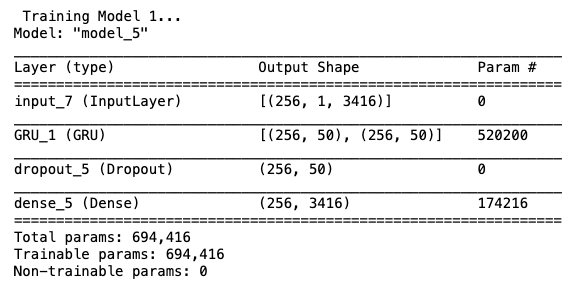  
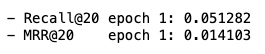  
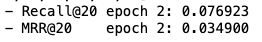  
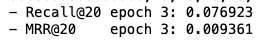  
  
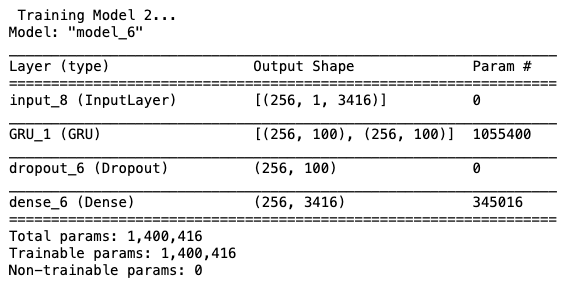  
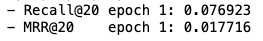  
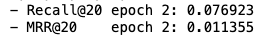  
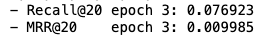  
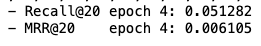  
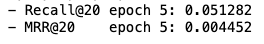  
  
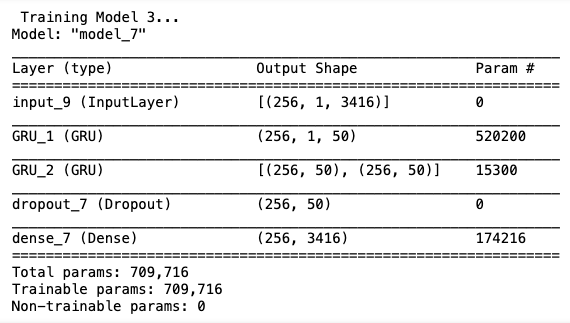  
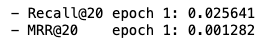  
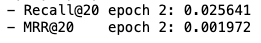  
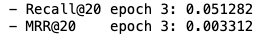  

In [75]:
print("최종 모델 성능 비교표:")
print(results_df)

최종 모델 성능 비교표:
     Model  GRU Layers  Hidden Size  Dropout  Learning Rate  Recall@K   MRR@K
0  Model 1           1           50      0.1          0.001    0.0227  0.0032
1  Model 2           1          100      0.3          0.001    0.0682  0.0088
2  Model 3           2           50      0.1          0.001    0.0682  0.0073


## 📝 비교 결과
- Model 1: 기본 설정 (50 hidden units, dropout 0.1)  
→ 가장 낮은 성능  
→ 모델 용량이 작고, Dropout도 낮고, epochs도 3번만 진행
  
  
- Model 2: Hidden Size를 100으로 키우고 Dropout을 0.3으로 높임  
→ Recall과 MRR이 가장 높음, 세 개의 모델 중 가장 효과적인 조합
→ 그러나, epochs을 5번 진행하는 과정에서 오히려 4번째부터는 성능이 하락한 것으로 보인다.
    - Dropout이 0.3으로 높은 편이라, epoch가 진행되면서 과적합이나 정보 손실이 있지 않았을까?
  
  
- Model 3: GRU를 2층으로 쌓았지만, 성능은 Model 2보다 약간 낮음  
→ 깊은 구조가 오히려 과적합이 발생하거나 성능이 불안정할 수 있어 보인다.  
→ 그러나 2 epoch까지는 성능이 낮다가, 3 epoch부터 올라간 것으로 보아 복잡한 모델은 epochs을 조금 늘려봐도 괜찮을까 싶다.
